# Deep Learning: Sentiment Analysis

- In this unit, we will build a deep-learning-based sentiment classifier on the movie reviews from `ntlk`.

![](../images/keras-workflow.png)

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0)
             for (text, label) in documents]

random.shuffle(documents)

In [3]:
documents[1]

('albert brooks saves the day , just in the nick of time . with a very poor summer for movies , brooks is just what audiences were looking for to cheer them up , and does so in a positive way . while this may not be his finest work , " the muse " still shakes up some delightful humor . in albert brook \' s latest comedy , he tells a story of a troubled screenwriter ( brooks ) who \' s losing his edge , as his business partners say . in desperation , he goes to see his friend jack ( jeff bridges ) , who has been a very successful screenwriter in the past . he asks jack for some help , and recieves word of a real life muse , that has helped him and many other directors throughout their career . so brooks seeks the muse named sarah ( sharon stone ) , and is suckered into buying her expensive , food etc . as a sort of payment . the real punch line however , doesn \' t come until the end . it really makes you wonder , how screenwriters really get their ideas , could it simply be from a frie

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- For text vectorization, we will implement two alternatives:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of all word tokens in texts and we will learn token **embeddings** along with the networks

- Important Steps:
    - Split data into **X** (texts) and **y** (sentiment labels)
    - Initialize `Tokenizer`
    - Use the `Tokenizer` for `text_to_sequences()` or `text_to_matrix()`
    - Padding the sequences to uniform lengths if needed (this can be either the max length of the sequences or any arbitrary length)
    

In [5]:
## Dependencies
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D

2023-07-18 17:06:37.676881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
## Split data into X (texts) and y (labels)
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set]

In [7]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- Important Notes:
    - We set the `num_words` at **10000**, meaning that the `Tokenizer` will automatically include only the most frequent **10000** words in the later text vectorization.
    - In other words, when we perform `text_to_sequences()` later, the `Tokenizer` will automatically remove words that are NOT in the top 10000 words.
    - However, the `tokenizer` still keeps the integer indices of all the words in the training texts (i.e., `tokenizer.word_index`)

In [8]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- If `oov_token` is specified, then the vocabulary size needs to be added one more.
- When `oov_token` is specified, the unknown word tokens (i.e., words that are not in the top 10000 words) will be replaced with this `oov_token` token, instead of being removed from the texts.

In [9]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 10001


In [10]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('this', 15),
 ('his', 16),
 ('film', 17),
 ('he', 18),
 ('i', 19),
 ('but', 20)]

In [11]:
len(tokenizer.word_index)

37693

## Define X and Y (Text Vectorization)

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [12]:
texts_ints = tokenizer.texts_to_sequences(texts)

In [13]:
print(len(texts[1000].split(' ')))  ## original text word number
print(len(texts_ints[1000]))  ## sequence token number

1081
844


#### Padding

- When dealing with texts and documents, padding each text to the **maximum length** may not be ideal. 
- For example, for sentiment classification, it is usually the case that authors would more clearly reveal/highlight his/her sentiment at the end of the text. 
- Therefore, we can specify an arbitrary `max_len` in padding the sequences to (a) reduce the risk of including too much noise in our model, and (b) speed up the training steps.

/Users/alvinchen/opt/anaconda3/envs/python-notes-2023/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


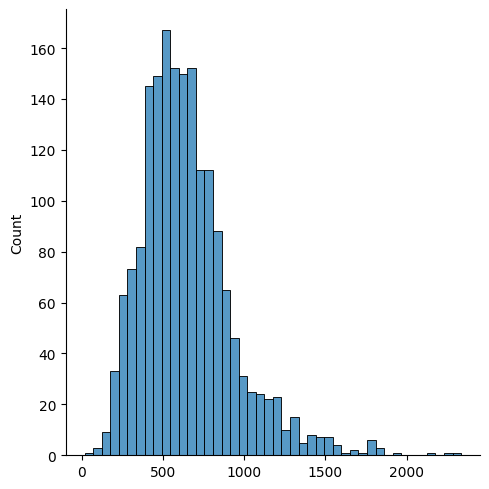

In [14]:
## Check the text len distribution
texts_lens = [len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [15]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2335

- In this tutorial, we consider only the **final** 400 tokens of each text, using the following parameters for `pad_sequences()`.
    - We keep the final 400 tokens from the text (`truncating='pre'`).
    - If the text is shorter than 400 tokens, we pad the text to 400 tokens at the beginning of the text (`padding='pre'`).

In [16]:
## Padding
max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints,
                                        maxlen=max_len,
                                        truncating='pre',
                                        padding='pre')
texts_ints_pad[:10]

array([[   0,    0,    0, ...,  387,    3, 7708],
       [ 270,   71, 4537, ...,    1,   17,  344],
       [1816,  519,   19, ...,   30,  334, 7291],
       ...,
       [ 118, 8224,    3, ...,   15,   17,  326],
       [   3, 6605, 4733, ...,    3,   64,  212],
       [ 109,  122, 1111, ...,   59,  763,  591]], dtype=int32)

In [17]:
## Gereate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

## Gereate X and y for testing in the same way
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [19]:
## Texts to One-Hot Encoding (bag of words)
texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

## Same for Testing Data
X_test2 = tokenizer.texts_to_matrix(X_test_texts,
                                    mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

In [20]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Hyperparameters

In [21]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

## Model Definition

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.002.jpeg)

In [23]:
## Model 1
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS, )))
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

2023-07-18 17:06:46.559952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


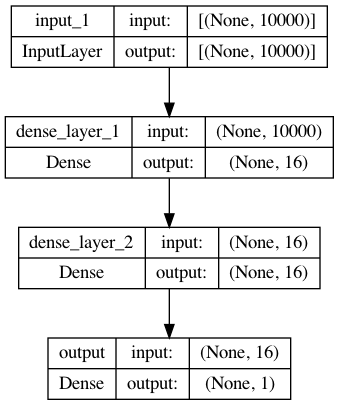

In [24]:
plot_model(model1, show_shapes=True)

In [25]:
history1 = model1.fit(X_train2,
                      y_train2,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25


12/12 - 1s - loss: 0.6661 - accuracy: 0.6153 - val_loss: 0.5989 - val_accuracy: 0.7472 - 826ms/epoch - 69ms/step
Epoch 2/25
12/12 - 0s - loss: 0.4854 - accuracy: 0.8701 - val_loss: 0.4883 - val_accuracy: 0.7694 - 81ms/epoch - 7ms/step
Epoch 3/25
12/12 - 0s - loss: 0.2994 - accuracy: 0.9389 - val_loss: 0.4121 - val_accuracy: 0.8056 - 83ms/epoch - 7ms/step
Epoch 4/25
12/12 - 0s - loss: 0.1714 - accuracy: 0.9819 - val_loss: 0.3589 - val_accuracy: 0.8528 - 85ms/epoch - 7ms/step
Epoch 5/25
12/12 - 0s - loss: 0.0929 - accuracy: 0.9951 - val_loss: 0.3412 - val_accuracy: 0.8639 - 86ms/epoch - 7ms/step
Epoch 6/25
12/12 - 0s - loss: 0.0519 - accuracy: 0.9986 - val_loss: 0.3421 - val_accuracy: 0.8583 - 81ms/epoch - 7ms/step
Epoch 7/25
12/12 - 0s - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.3287 - val_accuracy: 0.8583 - 85ms/epoch - 7ms/step
Epoch 8/25
12/12 - 0s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.3331 - val_accuracy: 0.8500 - 86ms/epoch - 7ms/step
Epoch 9/25
12/12 - 0s - loss: 0.0

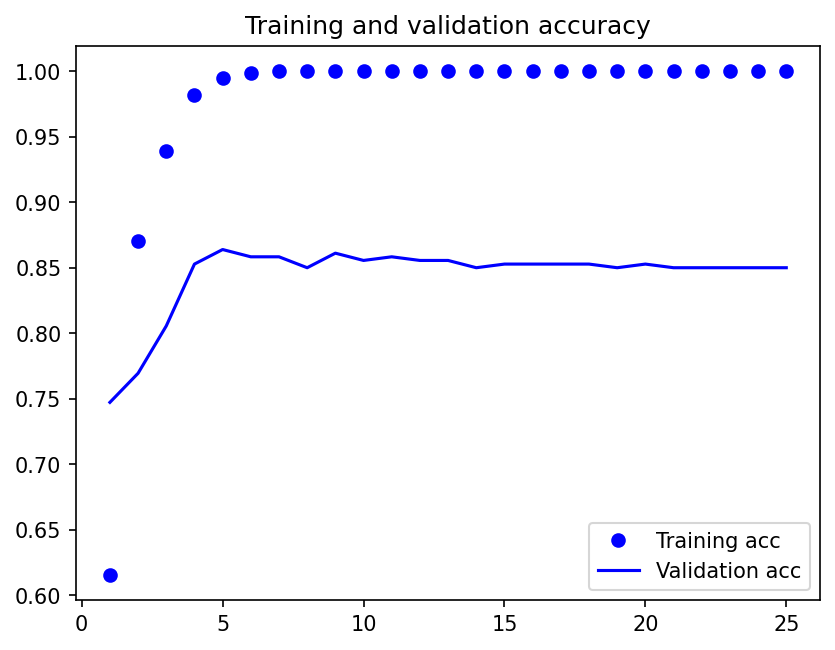

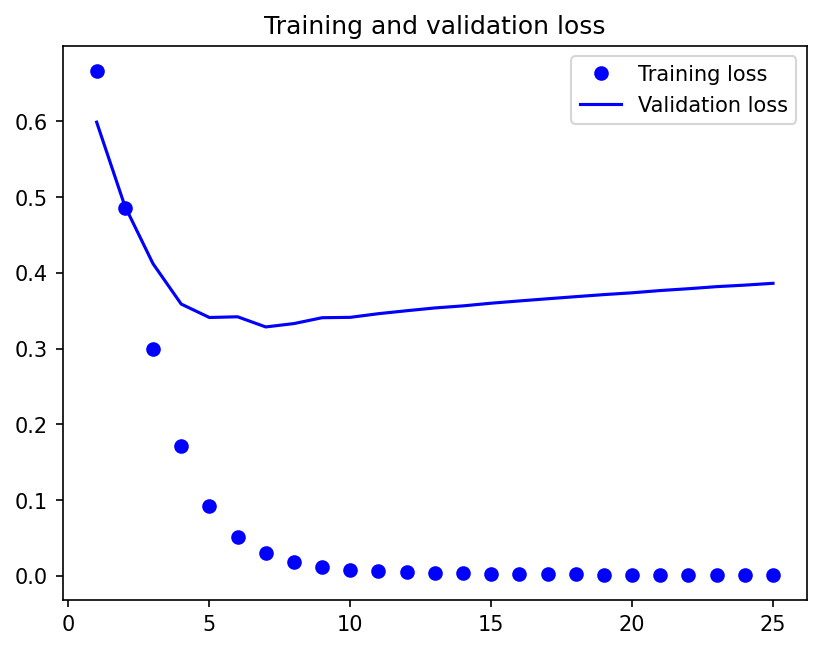

In [26]:
## Plot Training History
plot1(history1)

In [27]:
## Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.4171 - accuracy: 0.8800 - 26ms/epoch - 13ms/step


[0.4171465337276459, 0.8799999952316284]

### Model 2

- One Embedding Layer + Two fully-connected dense layers
- The Inputs are the sequences (integers) of texts.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.004.jpeg)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.008.jpeg)

In [28]:
## Model 2
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model2.add(
    GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(Dense(16, activation="relu", name="dense_layer_1"))
model2.add(Dense(16, activation="relu", name="dense_layer_2"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

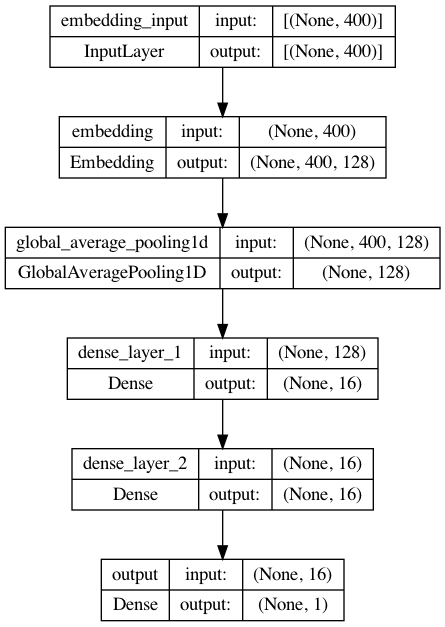

In [29]:
plot_model(model2, show_shapes=True)

In [30]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25


12/12 - 1s - loss: 0.6932 - accuracy: 0.5181 - val_loss: 0.6927 - val_accuracy: 0.5306 - 1s/epoch - 117ms/step
Epoch 2/25
12/12 - 0s - loss: 0.6919 - accuracy: 0.5972 - val_loss: 0.6913 - val_accuracy: 0.5611 - 492ms/epoch - 41ms/step
Epoch 3/25
12/12 - 0s - loss: 0.6892 - accuracy: 0.5493 - val_loss: 0.6886 - val_accuracy: 0.6667 - 481ms/epoch - 40ms/step
Epoch 4/25
12/12 - 0s - loss: 0.6829 - accuracy: 0.7708 - val_loss: 0.6830 - val_accuracy: 0.6889 - 476ms/epoch - 40ms/step
Epoch 5/25
12/12 - 0s - loss: 0.6713 - accuracy: 0.8250 - val_loss: 0.6729 - val_accuracy: 0.7222 - 455ms/epoch - 38ms/step
Epoch 6/25
12/12 - 0s - loss: 0.6500 - accuracy: 0.8431 - val_loss: 0.6555 - val_accuracy: 0.7306 - 461ms/epoch - 38ms/step
Epoch 7/25
12/12 - 0s - loss: 0.6134 - accuracy: 0.8667 - val_loss: 0.6264 - val_accuracy: 0.7806 - 463ms/epoch - 39ms/step
Epoch 8/25
12/12 - 0s - loss: 0.5555 - accuracy: 0.9056 - val_loss: 0.5866 - val_accuracy: 0.7861 - 465ms/epoch - 39ms/step
Epoch 9/25
12/12 - 0s

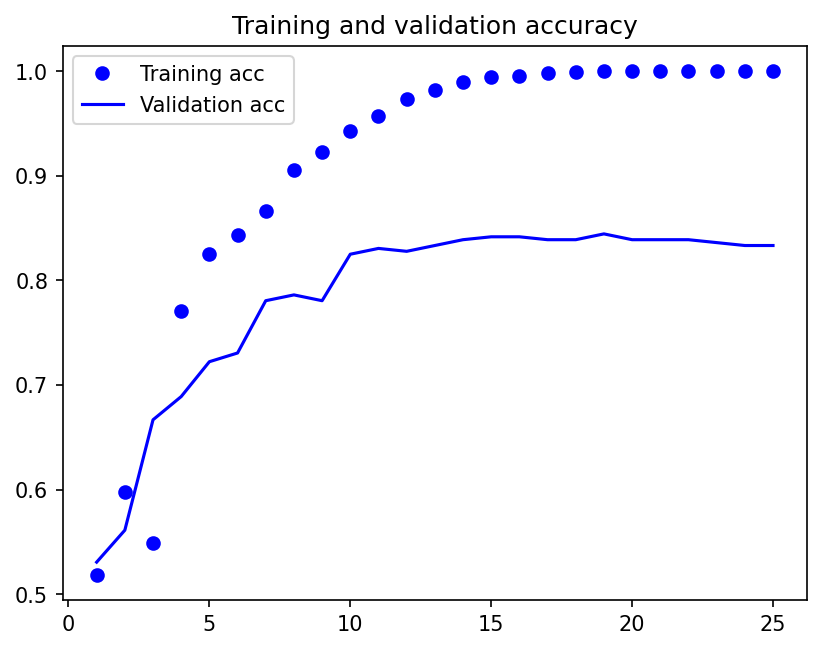

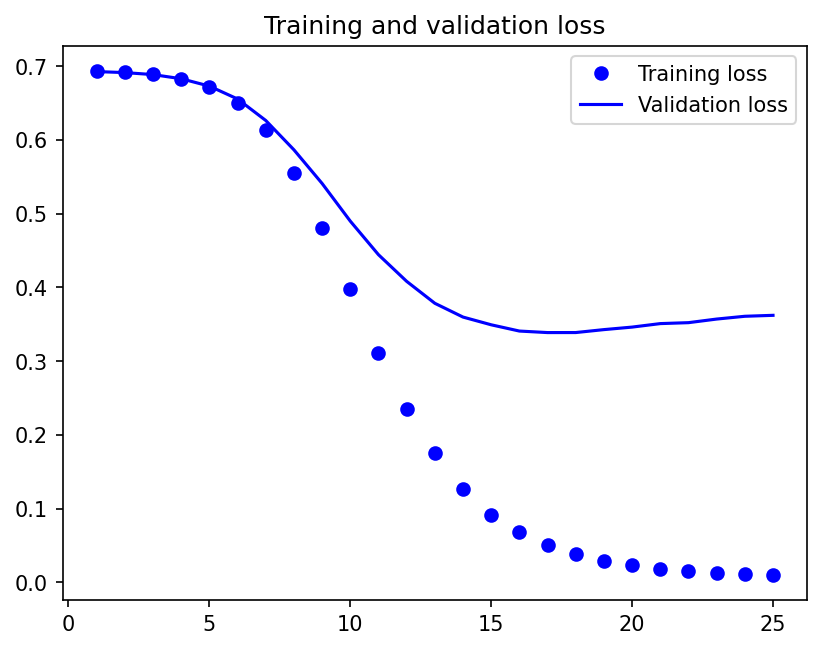

In [31]:
plot1(history2)

In [32]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3511 - accuracy: 0.8300 - 42ms/epoch - 21ms/step


[0.3511461019515991, 0.8299999833106995]

## Issues of Word/Character Representations

- Generally speaking, we can train our **word embeddings** along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these unsupervised methods later.

## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.012.jpeg)

In [33]:
## Model 3
model3 = Sequential()
model3.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

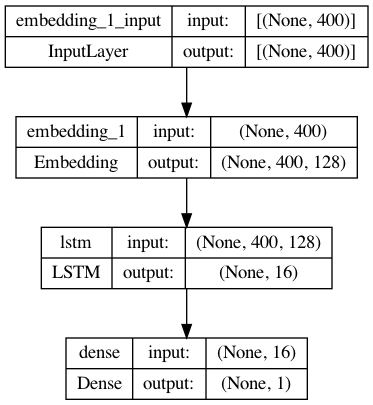

In [34]:
plot_model(model3, show_shapes=True)

In [35]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25


12/12 - 7s - loss: 0.6928 - accuracy: 0.5083 - val_loss: 0.6913 - val_accuracy: 0.5389 - 7s/epoch - 613ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6819 - accuracy: 0.6931 - val_loss: 0.6864 - val_accuracy: 0.6111 - 4s/epoch - 339ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6619 - accuracy: 0.8292 - val_loss: 0.6760 - val_accuracy: 0.6583 - 4s/epoch - 334ms/step
Epoch 4/25
12/12 - 4s - loss: 0.6156 - accuracy: 0.8729 - val_loss: 0.6518 - val_accuracy: 0.6722 - 4s/epoch - 330ms/step
Epoch 5/25
12/12 - 5s - loss: 0.5028 - accuracy: 0.8806 - val_loss: 0.5651 - val_accuracy: 0.7194 - 5s/epoch - 376ms/step
Epoch 6/25
12/12 - 4s - loss: 0.3366 - accuracy: 0.9215 - val_loss: 0.5111 - val_accuracy: 0.7472 - 4s/epoch - 360ms/step
Epoch 7/25
12/12 - 4s - loss: 0.2156 - accuracy: 0.9660 - val_loss: 0.4667 - val_accuracy: 0.7944 - 4s/epoch - 365ms/step
Epoch 8/25
12/12 - 4s - loss: 0.1549 - accuracy: 0.9778 - val_loss: 0.5670 - val_accuracy: 0.7194 - 4s/epoch - 357ms/step
Epoch 9/25
12/12 - 4s - loss: 0.142

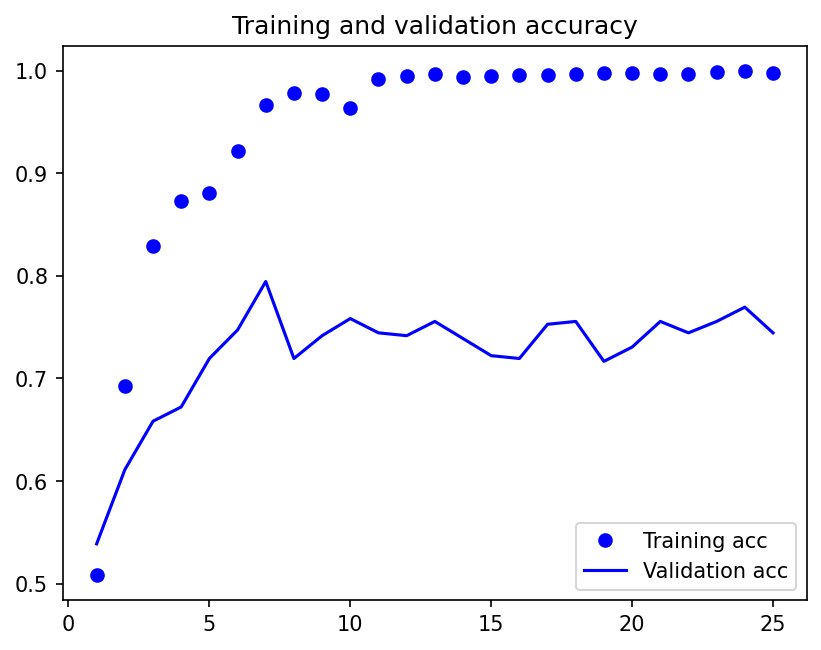

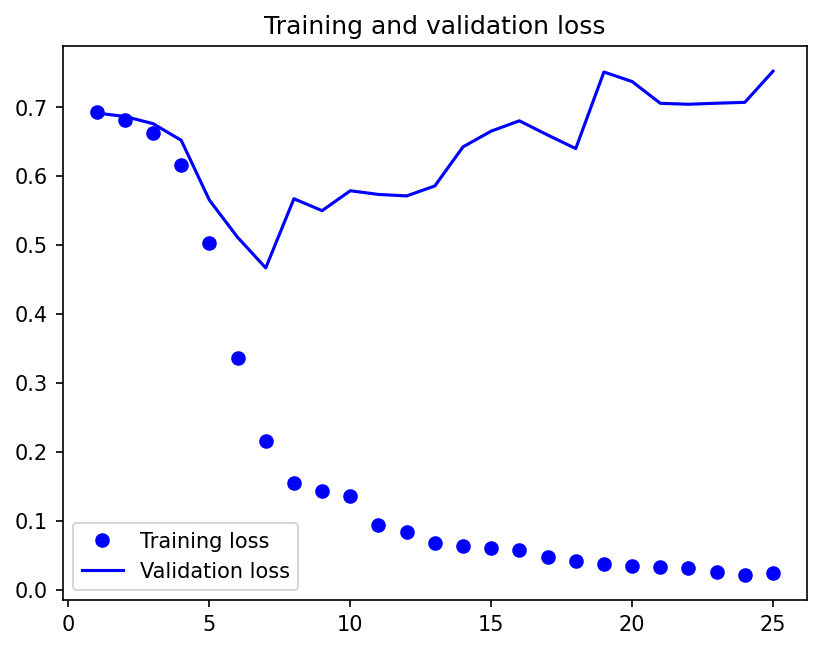

In [36]:
plot1(history3)

In [37]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.8008 - accuracy: 0.7450 - 150ms/epoch - 75ms/step


[0.8007545471191406, 0.7450000047683716]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer
- Inputs: text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.013.jpeg)

In [38]:
## Model 4
model4 = Sequential()
model4.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2,
                recurrent_dropout=0.2))  #)
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

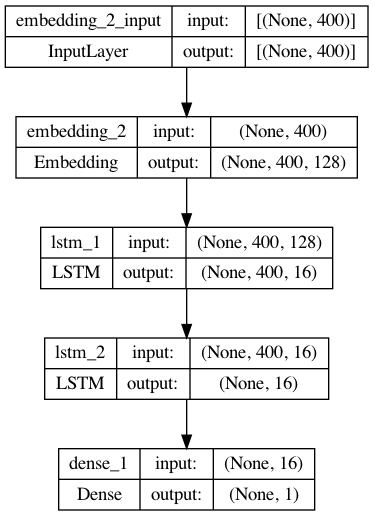

In [39]:
plot_model(model4, show_shapes=True)

In [40]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25


12/12 - 12s - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6919 - val_accuracy: 0.6111 - 12s/epoch - 1s/step
Epoch 2/25
12/12 - 6s - loss: 0.6873 - accuracy: 0.7319 - val_loss: 0.6874 - val_accuracy: 0.6056 - 6s/epoch - 528ms/step
Epoch 3/25
12/12 - 6s - loss: 0.6580 - accuracy: 0.6944 - val_loss: 0.6546 - val_accuracy: 0.6667 - 6s/epoch - 530ms/step
Epoch 4/25
12/12 - 6s - loss: 0.5231 - accuracy: 0.8479 - val_loss: 0.5735 - val_accuracy: 0.7111 - 6s/epoch - 526ms/step
Epoch 5/25
12/12 - 7s - loss: 0.3257 - accuracy: 0.9187 - val_loss: 0.6066 - val_accuracy: 0.7361 - 7s/epoch - 545ms/step
Epoch 6/25
12/12 - 6s - loss: 0.1977 - accuracy: 0.9667 - val_loss: 0.6036 - val_accuracy: 0.7167 - 6s/epoch - 528ms/step
Epoch 7/25
12/12 - 6s - loss: 0.1123 - accuracy: 0.9889 - val_loss: 0.6180 - val_accuracy: 0.7389 - 6s/epoch - 528ms/step
Epoch 8/25
12/12 - 6s - loss: 0.0837 - accuracy: 0.9931 - val_loss: 0.7465 - val_accuracy: 0.7083 - 6s/epoch - 522ms/step
Epoch 9/25
12/12 - 6s - loss: 0.0578

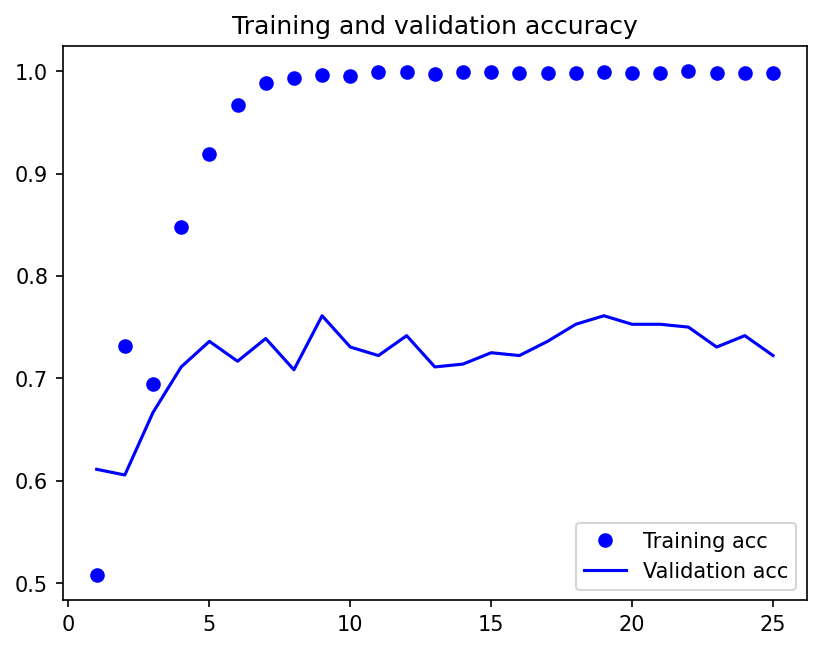

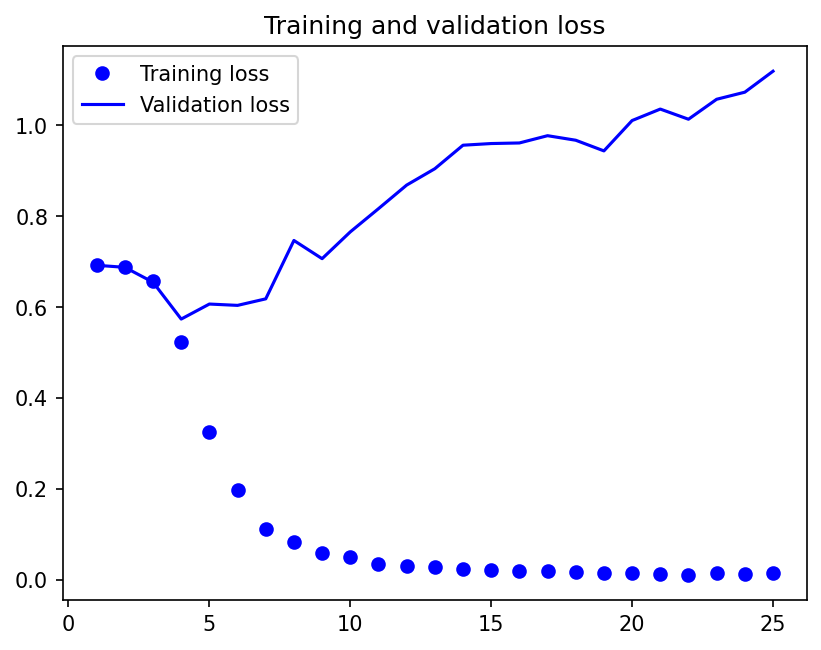

In [41]:
plot1(history4)

In [42]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.0515 - accuracy: 0.7400 - 199ms/epoch - 99ms/step


[1.0515365600585938, 0.7400000095367432]

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer
- Inputs: Text sequences (padded)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.014.jpeg)

In [43]:
## Model 5
model5 = Sequential()
model5.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

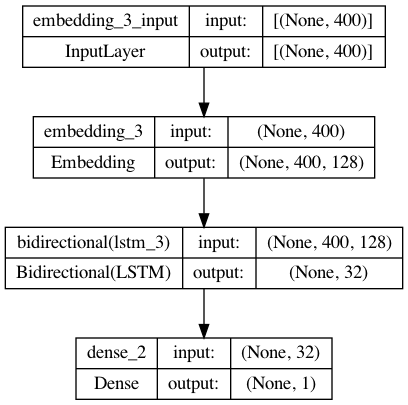

In [44]:
plot_model(model5, show_shapes=True)

In [45]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25


12/12 - 12s - loss: 0.6926 - accuracy: 0.5076 - val_loss: 0.6916 - val_accuracy: 0.5139 - 12s/epoch - 1s/step
Epoch 2/25
12/12 - 7s - loss: 0.6775 - accuracy: 0.7674 - val_loss: 0.6876 - val_accuracy: 0.5972 - 7s/epoch - 550ms/step
Epoch 3/25
12/12 - 6s - loss: 0.6490 - accuracy: 0.8972 - val_loss: 0.6789 - val_accuracy: 0.6278 - 6s/epoch - 538ms/step
Epoch 4/25
12/12 - 7s - loss: 0.5767 - accuracy: 0.8896 - val_loss: 0.6510 - val_accuracy: 0.6139 - 7s/epoch - 550ms/step
Epoch 5/25
12/12 - 7s - loss: 0.4101 - accuracy: 0.9049 - val_loss: 0.5579 - val_accuracy: 0.7028 - 7s/epoch - 547ms/step
Epoch 6/25
12/12 - 6s - loss: 0.2532 - accuracy: 0.9500 - val_loss: 0.5576 - val_accuracy: 0.7139 - 6s/epoch - 527ms/step
Epoch 7/25
12/12 - 6s - loss: 0.1881 - accuracy: 0.9861 - val_loss: 0.5422 - val_accuracy: 0.7167 - 6s/epoch - 519ms/step
Epoch 8/25
12/12 - 6s - loss: 0.1180 - accuracy: 0.9931 - val_loss: 0.5000 - val_accuracy: 0.7833 - 6s/epoch - 528ms/step
Epoch 9/25
12/12 - 6s - loss: 0.0708

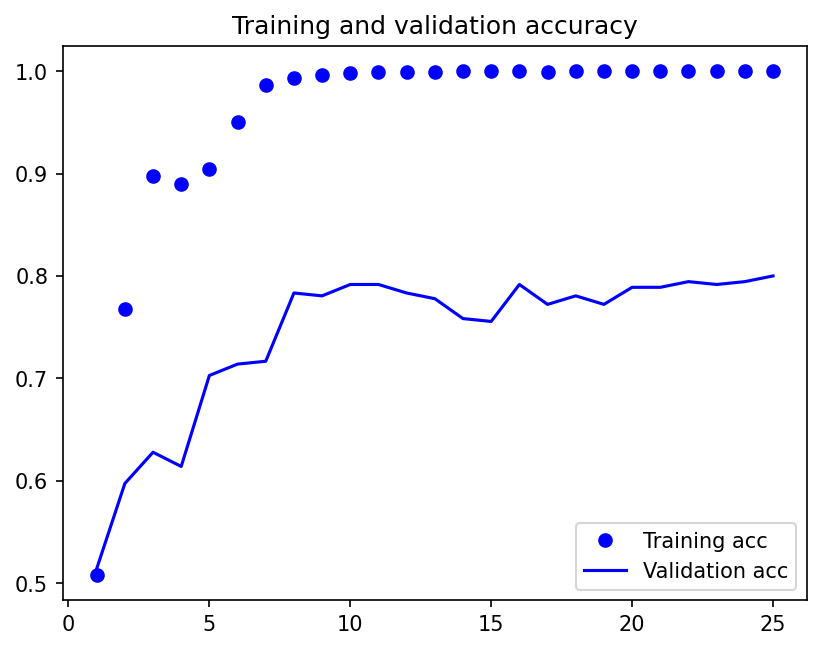

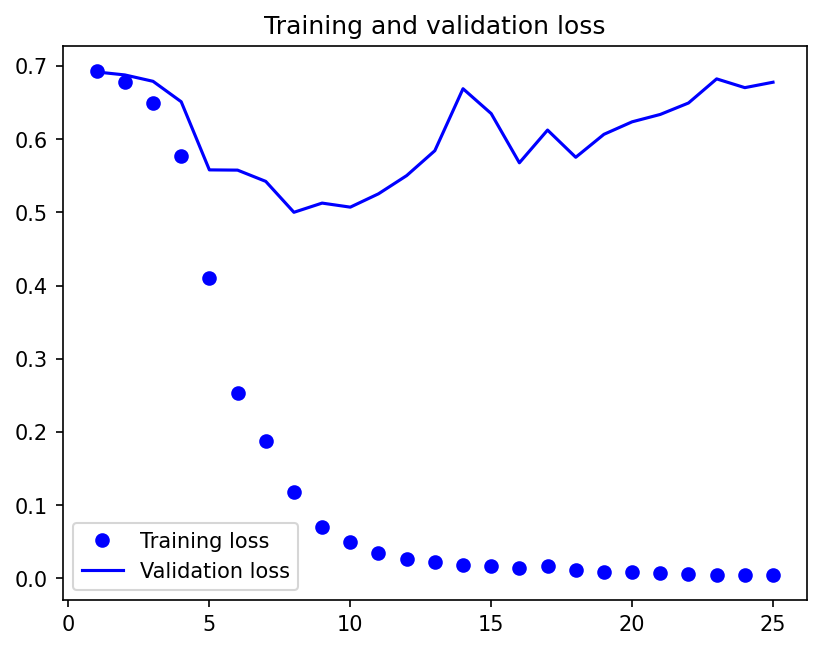

In [46]:
plot1(history5)

In [47]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6629 - accuracy: 0.8000 - 189ms/epoch - 95ms/step


[0.6628590226173401, 0.800000011920929]

## Even More Complex Sequence Models

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer
- Inputs: Text sequences (padded)

![](../images/chris-olah/LSTM3-chain-annotated.jpeg)
(Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.015.jpeg)

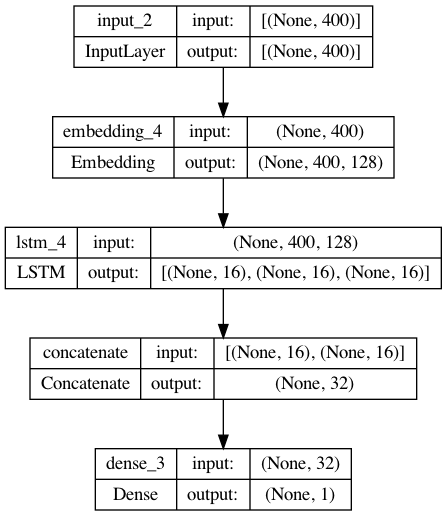

In [48]:
## Model 6

## Functional API
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
_, x_last_h, x_c = LSTM(16,
                        dropout=0.2,
                        recurrent_dropout=0.2,
                        return_sequences=False,
                        return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [49]:
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25


12/12 - 7s - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5833 - 7s/epoch - 616ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6796 - accuracy: 0.7389 - val_loss: 0.6847 - val_accuracy: 0.6139 - 4s/epoch - 330ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6532 - accuracy: 0.8250 - val_loss: 0.6701 - val_accuracy: 0.6528 - 4s/epoch - 321ms/step
Epoch 4/25
12/12 - 4s - loss: 0.5812 - accuracy: 0.8326 - val_loss: 0.6420 - val_accuracy: 0.6194 - 4s/epoch - 324ms/step
Epoch 5/25
12/12 - 4s - loss: 0.4015 - accuracy: 0.8715 - val_loss: 0.5465 - val_accuracy: 0.7278 - 4s/epoch - 314ms/step
Epoch 6/25
12/12 - 4s - loss: 0.2535 - accuracy: 0.9312 - val_loss: 0.5439 - val_accuracy: 0.7250 - 4s/epoch - 320ms/step
Epoch 7/25
12/12 - 4s - loss: 0.1548 - accuracy: 0.9757 - val_loss: 0.5518 - val_accuracy: 0.7500 - 4s/epoch - 325ms/step
Epoch 8/25
12/12 - 4s - loss: 0.0936 - accuracy: 0.9875 - val_loss: 0.5866 - val_accuracy: 0.7417 - 4s/epoch - 323ms/step
Epoch 9/25
12/12 - 4s - loss: 0.057

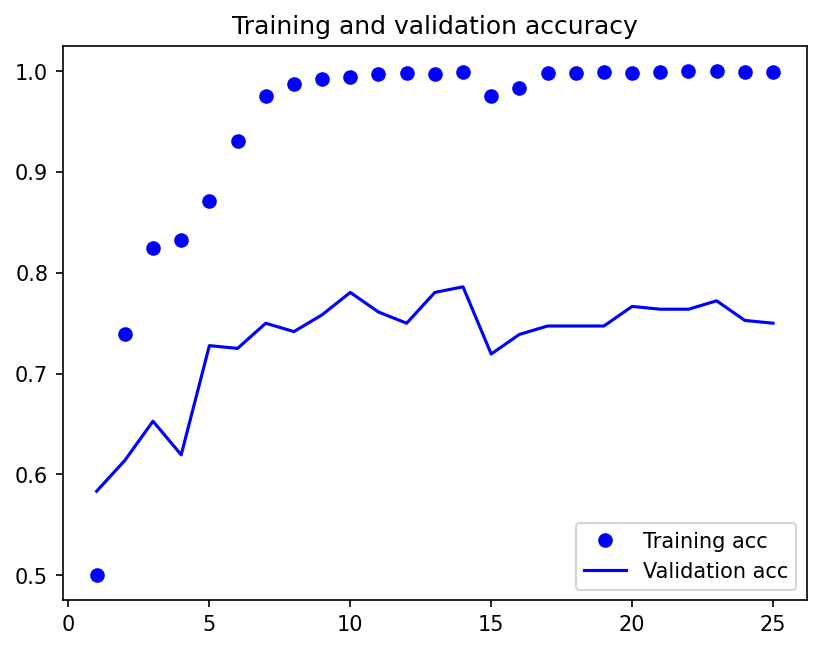

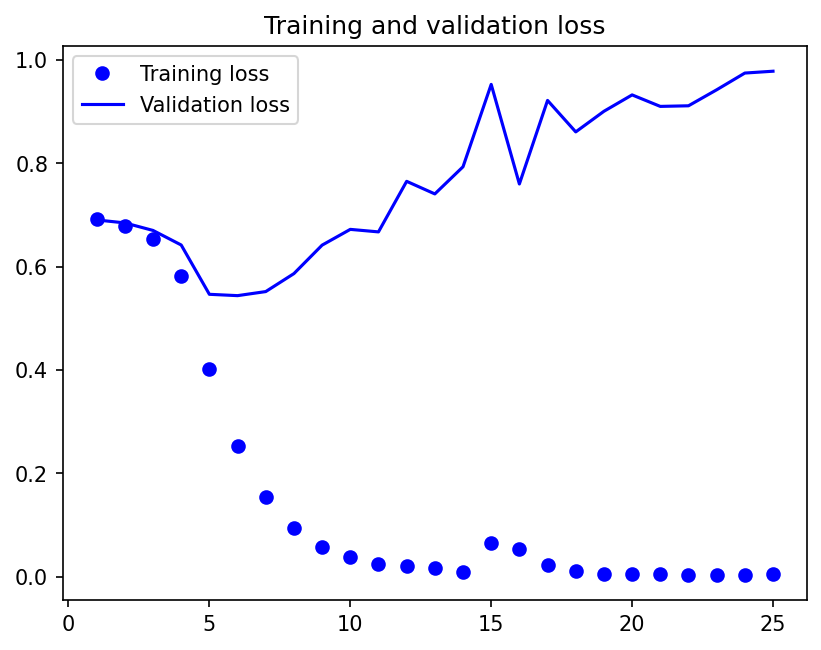

In [50]:
plot1(history6)

In [51]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.0289 - accuracy: 0.7600 - 147ms/epoch - 73ms/step


[1.0288810729980469, 0.7599999904632568]

### Model 7

- Embedding + LSTM + Self-Attention + Dense
- Inputs: Text sequences

- All of the previous RNN-based models only utilize the output of the **last time step** from the RNN as the input of the decision-making Dense layer.
- We can also make **all the hidden outputs** at all time steps from the RNN available to decision-making Dense layer.
- This is the idea of **Attention**.

![](../images/seq2seq-self-atten.gif)

- Here we add one `Self-Attention` layer, which gives us a weighted version of all the hidden states from the RNN.
- Self Attention layer is a simple sequence-to-sequence layer, which takes in a set of input tensors and returns a set of output tensors. 
- In Self Attention Layer, each output vector is transformed by considering the pairwise similarities of its corresponding input vector and all the other input vectors. 
- We will come back to the Attention mechanism in the later unit for more details.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.016.jpeg)

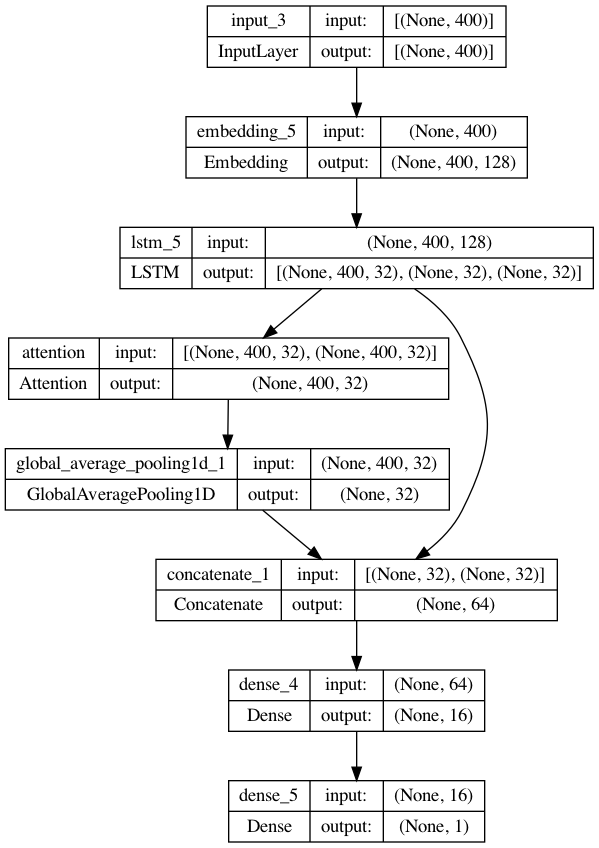

In [52]:
## Model 7 (Self-Attention)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs])  # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [53]:
# ## Model 7 (Attention of lasth on allh)

# inputs = Input(shape=(max_len,))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)
# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(x)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# ## Self Attention
# atten_out = Attention()([x_last_h, x_all_hs])  # Attention of last hidden states on all preceding states
# atten_out_average = layers.GlobalMaxPooling1D()(atten_out)

# x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
# x = Dense(16, activation="relu")(x_last_h_plus_atten)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [54]:
# ## Model 7 (Self-Attention before RNN)

# inputs = Input(shape=(max_len, ))
# x = Embedding(input_dim=vocab_size,
#               output_dim=EMBEDDING_DIM,
#               input_length=max_len,
#               mask_zero=True)(inputs)

# atten_out = Attention()([x,x])

# x_all_hs, x_last_h, x_last_c = LSTM(32,
#                                     dropout=0.2,
#                                     recurrent_dropout=0.2,
#                                     return_sequences=True,
#                                     return_state=True)(atten_out)
# ## LSTM Parameters:
# #     `return_seqeunces=True`: return the hidden states for each time step
# #     `return_state=True`: return the cell state of the last time step
# #     When both are set True, the return values of LSTM are:
# #     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
# #     (2) the hidden state of the last time step
# #     (3) the cell state of the last time step

# x = Dense(16, activation="relu")(x_last_h)
# outputs = Dense(1, activation='sigmoid')(x)
# model7 = Model(inputs=inputs, outputs=outputs)

# plot_model(model7, show_shapes=True)

In [55]:
model7.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history7 = model7.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25


12/12 - 12s - loss: 0.6926 - accuracy: 0.5243 - val_loss: 0.6906 - val_accuracy: 0.6222 - 12s/epoch - 962ms/step
Epoch 2/25
12/12 - 8s - loss: 0.6823 - accuracy: 0.7806 - val_loss: 0.6797 - val_accuracy: 0.6694 - 8s/epoch - 673ms/step
Epoch 3/25
12/12 - 8s - loss: 0.6306 - accuracy: 0.8528 - val_loss: 0.5988 - val_accuracy: 0.6806 - 8s/epoch - 669ms/step
Epoch 4/25
12/12 - 8s - loss: 0.4842 - accuracy: 0.7750 - val_loss: 0.5149 - val_accuracy: 0.7500 - 8s/epoch - 659ms/step
Epoch 5/25
12/12 - 8s - loss: 0.3531 - accuracy: 0.9187 - val_loss: 0.4618 - val_accuracy: 0.7917 - 8s/epoch - 658ms/step
Epoch 6/25
12/12 - 8s - loss: 0.2014 - accuracy: 0.9514 - val_loss: 0.4212 - val_accuracy: 0.8111 - 8s/epoch - 658ms/step
Epoch 7/25
12/12 - 8s - loss: 0.1085 - accuracy: 0.9812 - val_loss: 0.4854 - val_accuracy: 0.7944 - 8s/epoch - 667ms/step
Epoch 8/25
12/12 - 8s - loss: 0.0627 - accuracy: 0.9868 - val_loss: 0.5426 - val_accuracy: 0.8028 - 8s/epoch - 659ms/step
Epoch 9/25
12/12 - 8s - loss: 0.0

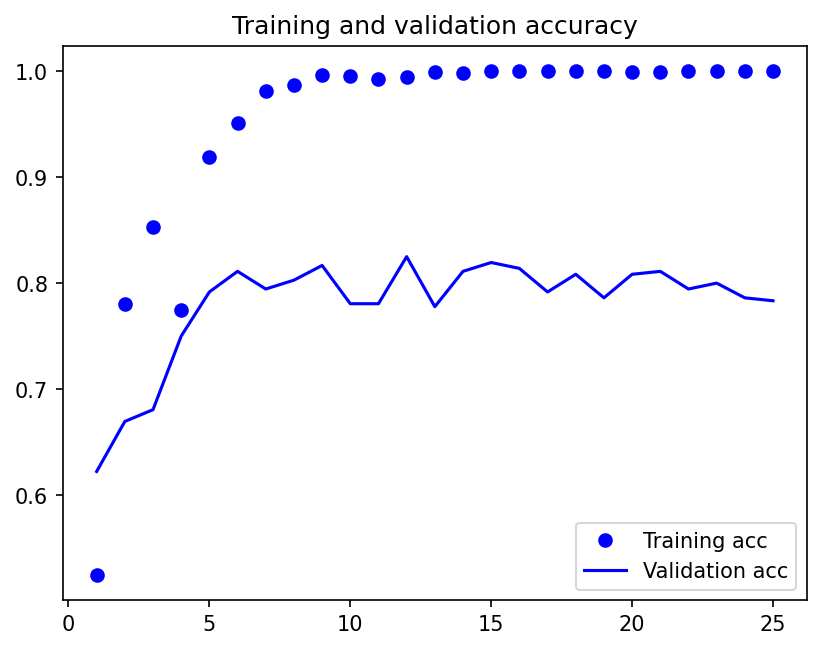

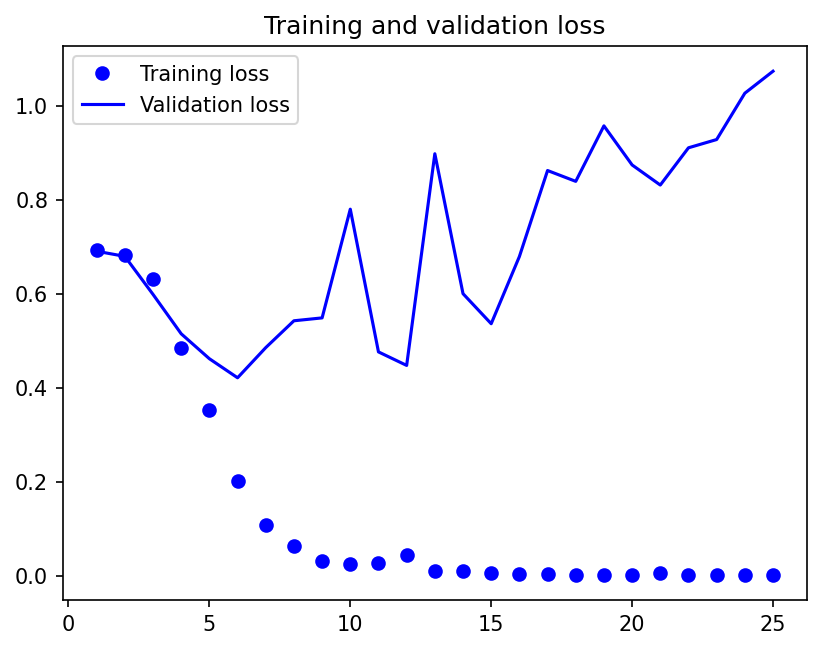

In [56]:
plot1(history7)

In [57]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.0072 - accuracy: 0.8200 - 363ms/epoch - 182ms/step


[1.007235050201416, 0.8199999928474426]

## Explanation

- We use LIME for model explanation.
- Let's inspect the Attention-based Model (model7).

:::{warning}
In our current experiments, we have not considered very carefully the issue of model over-fitting. To optimize the network, it is necessary to include **regularization** and **dropouts** to reduce the variation of the model performance on unseen datasets (i.e., **generalization**).
:::

In [58]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'],
                              char_level=False)

## Select the best model so far
best_model = model7

In [59]:
## Pipeline for LIME
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1 - x), float(x)]
                     for x in best_model.predict(np.array(_seq_pad))])

In [60]:
text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id],
                                 model_predict_pipeline,
                                 num_features=20,
                                 top_labels=1)
exp.show_in_notebook(text=True)

157/157 [==============================] - 8s 47ms/step


/var/folders/0v/47nxlfjn26536t51wxj9j6q40000gn/T/ipykernel_22296/3994166592.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([[float(1 - x), float(x)]


In [61]:
exp.show_in_notebook(text=True)

## Check Embeddings

- We can also examine the word embeddings learned along with our Classifier.
- Steps include:
    - Extract the embedding weights from the trained model.
    - Determine words we would like to inspect.
    - Extract the embeddings of these words.
    - Use dimensional reduction techniques to plot word embeddings in a 2D graph.

In [62]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [63]:
## Mapping of embeddings and word-labels
token_labels = [
    word for (ind, word) in tokenizer.index_word.items()
    if ind < word_vectors.shape[0]
]
token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [64]:
len(token_labels)

10001

- Because there are many words, we select words for visualization based on the following criteria:
    - Include embeddings of words that are not on the English stopword list (`nltk.corpus.stopwords.words('english')`) and whose word length >= 5 (characters)

In [65]:
from sklearn.manifold import TSNE
stopword_list = nltk.corpus.stopwords.words('english')

In [66]:
out_index = [
    i for i, w in enumerate(token_labels)
    if len(w) >= 5 and w not in stopword_list
]
len(out_index)

8202

In [67]:
out_index[:10]

[26, 69, 70, 73, 82, 83, 90, 97, 99, 102]

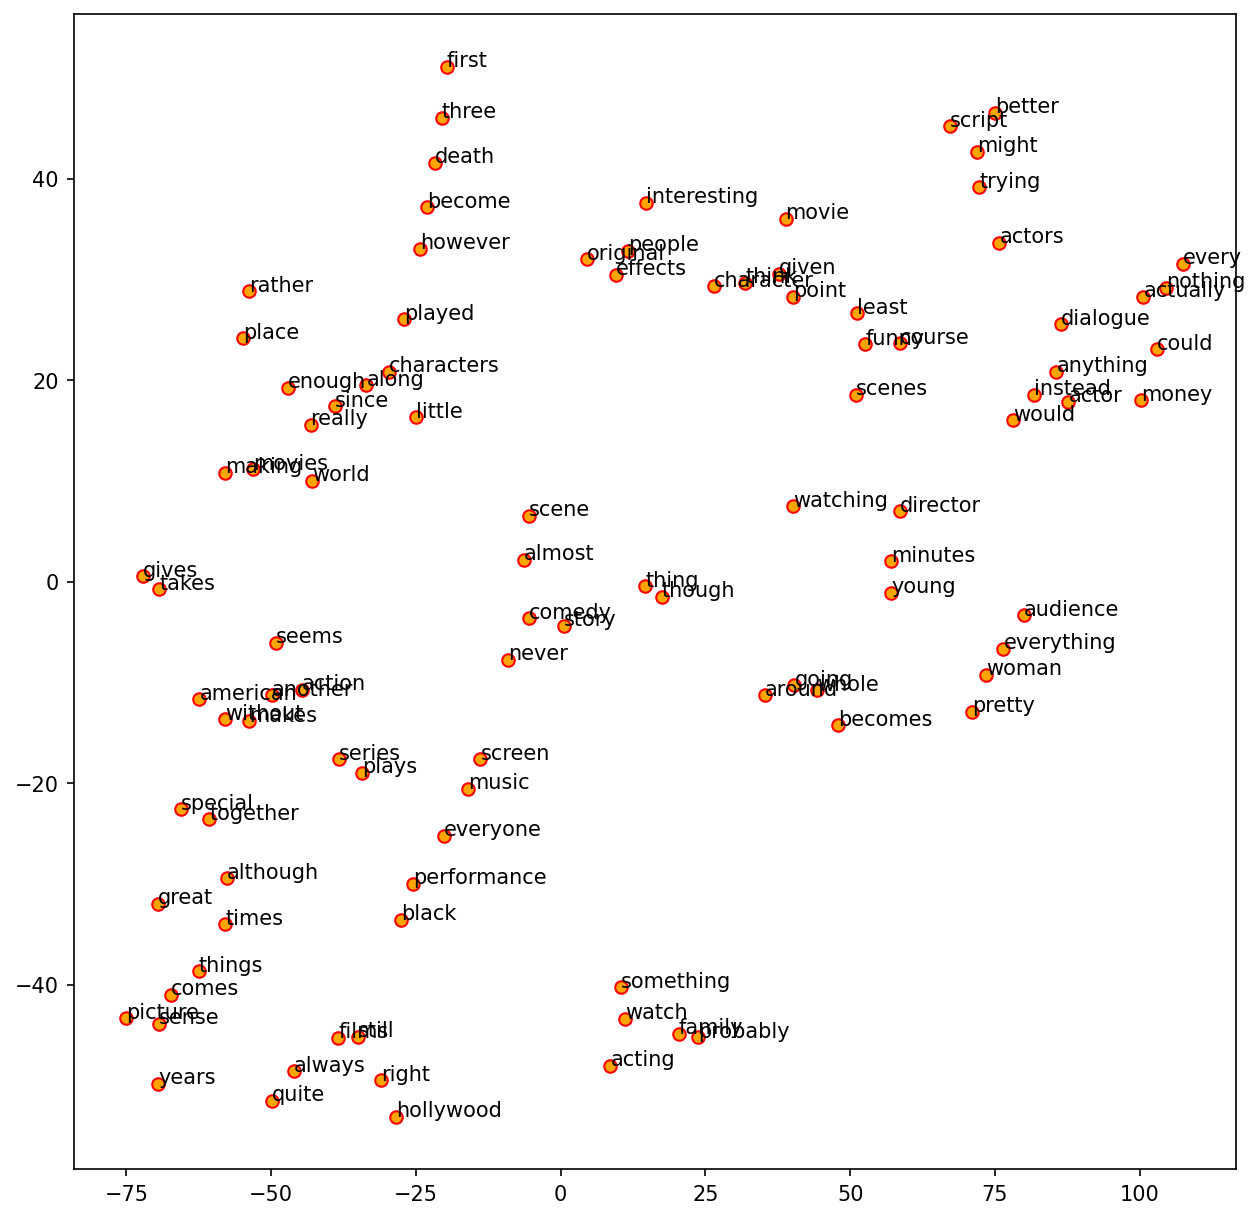

In [68]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100], ])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.01, y + 0.01),
                 xytext=(0, 0),
                 textcoords='offset points')

## Model Comparisons

- Let's compare the learning performance of all the models by examining their changes of accuracies and losses in each epoch of training.

In [69]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

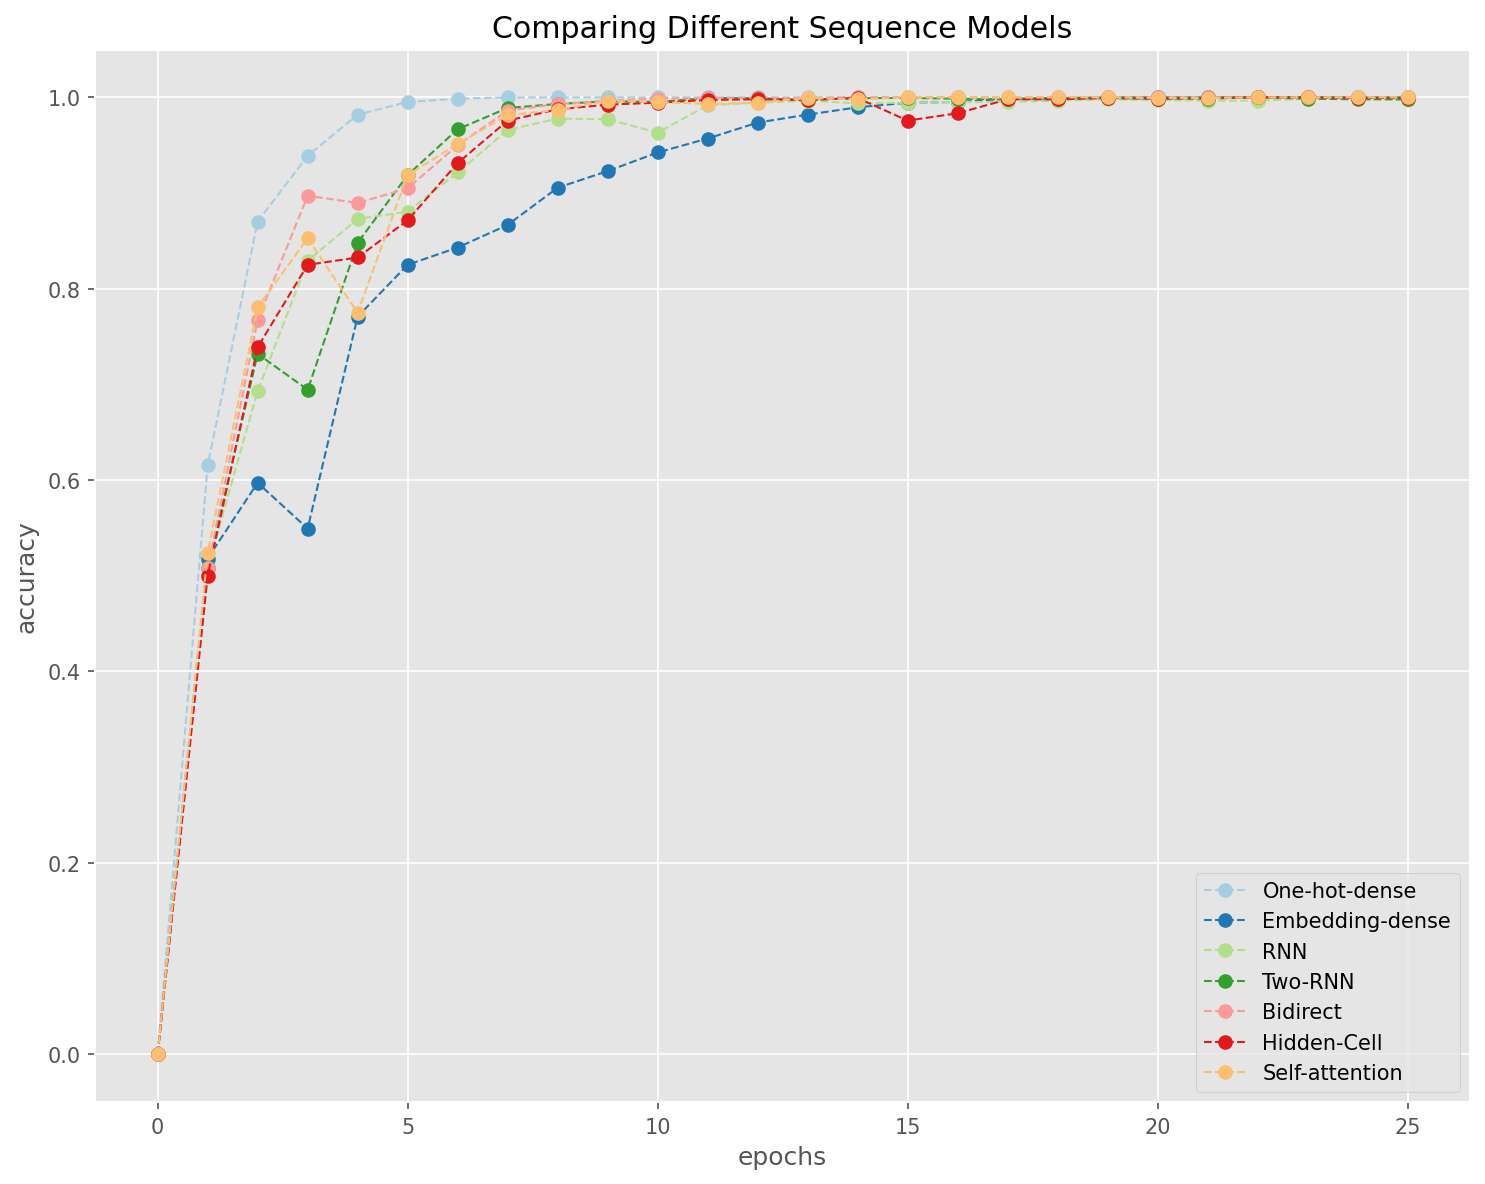

In [70]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

- General Observations
    - Fully-connected network works better with one-hot encoding of texts (i.e., bag-of-words vectorized representations of texts)
    - Embeddings are more useful when working with sequence models (e.g., RNN).
    - The self-attention layer, in our current case, is on the entire input sequence, and therefore is limited in its effects.

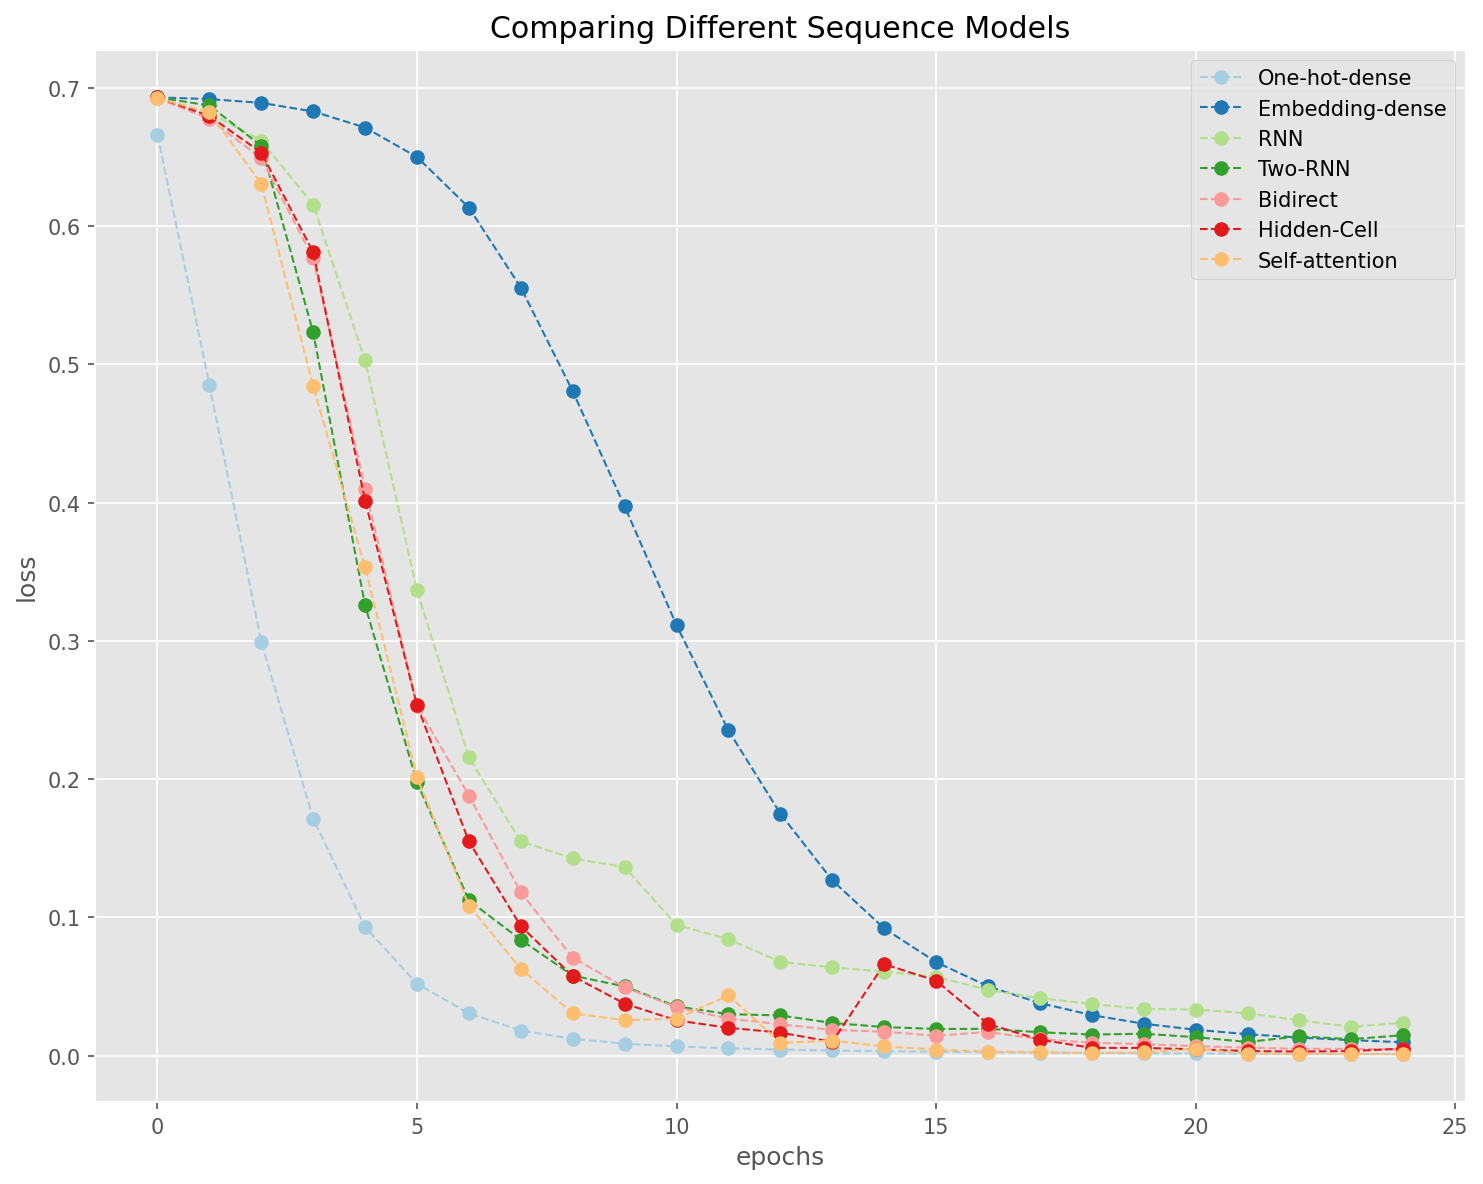

In [71]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()